In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today

In [6]:
date_str = "2024_01_03"
df_hourly = get_energy_data_today(to_date=date_str.replace("_", ""))

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df


---

In [7]:
# lead times are
horizons = [36, 40, 44, 60, 64, 68] #[24 + 12*i for i in range(5)]

def get_date_from_horizon(last_ts, horizon):
    
    """ adds horizon hours to timeindex last_ts """
    
    return last_ts + pd.DateOffset(hours = horizon)

LAST_IDX = -1
LAST_DATE = df_hourly.iloc[LAST_IDX].name
print(LAST_DATE)

thursday = LAST_DATE + pd.DateOffset(days=(3-LAST_DATE.weekday())%7)
thursday = thursday.replace(hour=0, minute=0, second=0, microsecond=0)
print(thursday)

horizon_date = [get_date_from_horizon(thursday, h) for h in horizons]
print(horizon_date)

2024-01-03 22:00:00+00:00
2024-01-04 00:00:00+00:00
[Timestamp('2024-01-05 12:00:00+0000', tz='UTC'), Timestamp('2024-01-05 16:00:00+0000', tz='UTC'), Timestamp('2024-01-05 20:00:00+0000', tz='UTC'), Timestamp('2024-01-06 12:00:00+0000', tz='UTC'), Timestamp('2024-01-06 16:00:00+0000', tz='UTC'), Timestamp('2024-01-06 20:00:00+0000', tz='UTC')]


In [8]:
# wanted to get closest weekday that is comparable in past year
# but in the worst case ... ie 21.2023
# the date in the past year with the same weekday is 22.2022 which is much closer to christmas

# - - - - - - - - - -

# # get past values of horizon dates from df_hourly dataframe

# past_yrs = np.arange(1,2)
# print(past_yrs)

# for past_yr in past_yrs : 

#     # shift horizon date by past_yr years back
#     old_horizon_date = [h - pd.DateOffset(years=past_yr) for h in horizon_date]
#     # also add all days between plus minus 7 days of old_horizon_date
#     old_horizon_date = old_horizon_date + [h + pd.DateOffset(days=d) for h in old_horizon_date for d in range(-7,8)]
#     # order dates
#     old_horizon_date.sort()

#     old_vals = df_hourly.loc[old_horizon_date]
#     print(old_vals.to_string())
    

In [12]:
tau = [.025, .25, .5, .75, .975]
last_t = 24*365*2

# add weekday col to dataframe based on timestamp_CET column
df_hourly['weekday'] = df_hourly['timestamp_CET'].dt.weekday

# rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

for i,d in enumerate(horizon_date):
    
    # Extract the weekday and hour from the date 'd'
    # (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) 
    weekday = d.weekday()
    hour = d.hour
    
    # Create a temporary DataFrame 'df_tmp' 
    # by selecting the first 'LAST_IDX' rows from the original DataFrame 'df'
    df_tmp = df_hourly.iloc[:LAST_IDX]
    
    # Define a condition 'cond' to filter rows in 'df_tmp' based on the weekday and time of day
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    # Calculate the quantiles of the 'gesamt' column in 'df_tmp' that meet the 'cond' condition
    # The quantiles are calculated for each 'tau' value, and the results are stored in 'pred_baseline'
    pred_baseline[i, :] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)

pred_baseline = pred_baseline / 1000
pred_baseline

array([[50.20586875, 61.592125  , 64.8805    , 68.8294375 , 73.32865   ],
       [52.16990625, 59.46025   , 62.19525   , 68.1903125 , 73.985     ],
       [46.03406875, 50.9771875 , 54.14225   , 60.1693125 , 64.73600625],
       [46.49343125, 51.669     , 53.555375  , 57.798125  , 62.48016875],
       [47.21196875, 51.1749375 , 53.38225   , 59.352625  , 65.00006875],
       [42.09105   , 46.021125  , 48.597625  , 53.566625  , 57.6413375 ]])

In [21]:
pred = np.array([[61.41275   , 68.3035    , 70.7496875 , 73.106     , 76.58525   ],
       [57.477     , 64.9755    , 67.6776875 , 69.9555    , 73.572     ],
       [56.76075   , 63.70725   , 66.3204375 , 68.3365    , 70.94      ],
       [52.63375   , 55.68725   , 57.30621875, 59.709     , 63.3695    ],
       [48.698     , 52.35925   , 54.23421875, 56.5585    , 60.35625   ],
       [47.98175   , 51.091     , 52.87696875, 54.9395    , 57.72425   ]])

ensemble_pred = (pred + pred_baseline) / 2
ensemble_pred

array([[55.80930937, 64.9478125 , 67.81509375, 70.96771875, 74.95695   ],
       [54.82345313, 62.217875  , 64.93646875, 69.07290625, 73.7785    ],
       [51.39740937, 57.34221875, 60.23134375, 64.25290625, 67.83800313],
       [49.56359063, 53.678125  , 55.43079687, 58.7535625 , 62.92483438],
       [47.95498437, 51.76709375, 53.80823437, 57.9555625 , 62.67815937],
       [45.0364    , 48.5560625 , 50.73729687, 54.2530625 , 57.68279375]])

Visually check if quantiles make sense

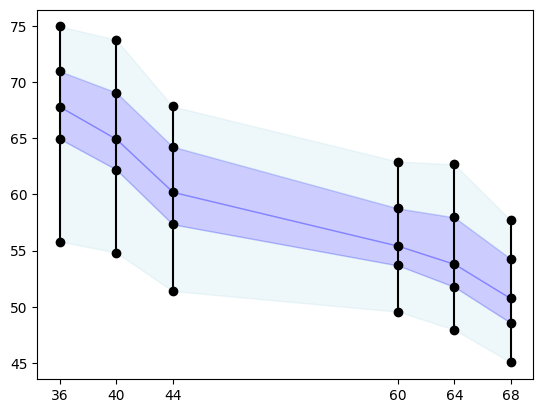

In [22]:
pred = ensemble_pred

x = horizons
quantiles = tau
# tau = [.025, .25, .5, .75, .975]

colors = ['lightblue', 'blue', 'blue', 'lightblue']

# Creating colored intervals between quantiles
for i in range(len(quantiles) - 1):
    plt.fill_between(
        horizons,
        pred[:, i],
        pred[:, i + 1],
        alpha=0.2,  # Adjust transparency as needed
        color=colors[i],
        label=f'Quantile {quantiles[i]} - {quantiles[i + 1]}',
    )

_ = plt.plot(x,pred, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred[:,0], pred[:,-1]),c='black')

In [36]:
df_sub = pd.DataFrame({
    
    "forecast_date": date_str.replace("_", "-"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons],
    "q0.025": pred[:,0],
    "q0.25": pred[:,1],
    "q0.5": pred[:,2],
    "q0.75": pred[:,3],
    "q0.975": pred[:,4]

})

df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03,energy,36 hour,55.809309,64.947812,67.815094,70.967719,74.956950
1,2024-01-03,energy,40 hour,54.823453,62.217875,64.936469,69.072906,73.778500
2,2024-01-03,energy,44 hour,51.397409,57.342219,60.231344,64.252906,67.838003
3,2024-01-03,energy,60 hour,49.563591,53.678125,55.430797,58.753563,62.924834
4,2024-01-03,energy,64 hour,47.954984,51.767094,53.808234,57.955562,62.678159
5,2024-01-03,energy,68 hour,45.036400,48.556062,50.737297,54.253062,57.682794


In [37]:
for row_to_check in range(df_sub.shape[0]):
    row_values = df_sub.iloc[row_to_check, 3:].values
    is_ordered = all(row_values[i] <= row_values[i + 1] for i in range(len(row_values) - 1))
    print(is_ordered)

True
True
True
True
True
True


In [38]:
PATH = f"C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/Submissions/{date_str}"
if not os.path.exists(PATH):
    # create folder if it does not exist
    os.makedirs(PATH)
df_sub.to_csv(PATH+"/"+date_str+"_power_benchmark.csv",index=False)